# Overview

This notebook uses PyTorch and PyTorch lightning to fine tune a pretrained ResNet image classification model on a new dataset.  This technique is called Transfer Learning

In [1]:
# imports
import sagemaker
from sagemaker.pytorch import PyTorch
from torchvision.datasets.utils import download_and_extract_archive
from PIL import Image
from torchvision import transforms as T
import torch.nn.functional as F
import numpy as np

In [2]:
# Configure SageMaker
sess = sagemaker.Session()
# sagemaker session bucket -> used for uploading data, models and logs
# sagemaker will automatically create this bucket if it does not exist
sagemaker_session_bucket=None
if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

role = sagemaker.get_execution_role()
sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sagemaker_session_bucket}")
print(f"sagemaker session region: {sess.boto_region_name}")

sagemaker role arn: arn:aws:iam::431615879134:role/sagemaker-test-role
sagemaker bucket: sagemaker-us-east-1-431615879134
sagemaker session region: us-east-1


# Data

For this example we will use the Imagewoof dataset from Fast.ai.  This dataset is a subset of the imagenet dataset that contain 10 different dog breeds.  The breeds are :

| Class | Breed |
| ------ | ------ |
| 0 | Shih-Tzu |
| 1 | Rhodesian ridgeback | 
| 2 | Beagle |
| 3 | English foxhound | 
| 4 | Australian terrier |
| 5 | Border terrier | 
| 6 | Golden retriever |
| 7 | Old English sheepdog | 
| 8 | Samoyed |
| 9 | Dingo | 

More information on imagewoof can be found [here](https://github.com/fastai/imagenette#imagewoof)


In [3]:
id2class = {
    0:'Shih-Tzu',
    1:'Rhodesian ridgeback',
    2:'Beagle',
    3:'English foxhound',
    4:'Australian terrier',
    5:'Border terrier',
    6:'Golden retriever',
    7:'Old English sheepdog',
    8:'Samoyed',
    9:'Dingo',
}

In [4]:
DATA_URL = 'https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2-320.tgz'

In [5]:
download_and_extract_archive(url=DATA_URL, download_root='./data/', remove_finished=True)

0it [00:00, ?it/s]

Extracting ./data/imagewoof2-320.tgz to ./data/


In [6]:
def show_image(fname):
    img = Image.open(fname)
    img.show()

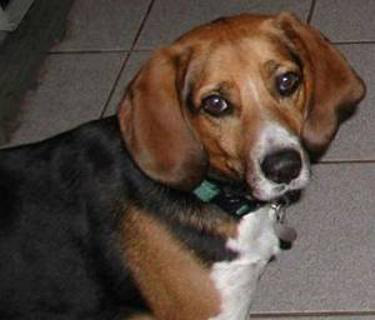

In [7]:
show_image('./data/imagewoof2-320/val/n02089973/n02089973_1.JPEG')

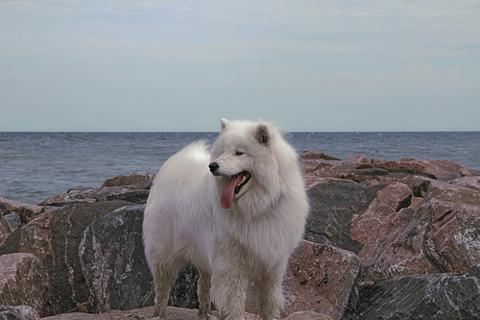

In [8]:
show_image('./data/imagewoof2-320/val/n02111889/ILSVRC2012_val_00021632.JPEG')

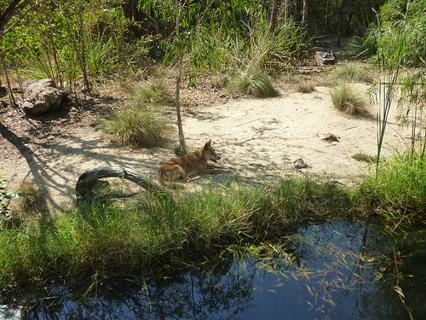

In [9]:
show_image('./data/imagewoof2-320/val/n02115641/n02115641_51492.JPEG')

In [10]:
%%time
!aws s3 cp ./data/ s3://{sagemaker_session_bucket}/dogbreed/data/ --recursive --quiet

CPU times: user 1.53 s, sys: 492 ms, total: 2.02 s
Wall time: 1min 23s


# Training

In [17]:
training_data = f's3://{sagemaker_session_bucket}/dogbreed/data/imagewoof2-320/train/'
validation_data = f's3://{sagemaker_session_bucket}/dogbreed/data/imagewoof2-320/val/'

print(training_data)
print(validation_data)

s3://sagemaker-us-east-1-431615879134/dogbreed/data/imagewoof2-320/train/
s3://sagemaker-us-east-1-431615879134/dogbreed/data/imagewoof2-320/val/


In [20]:
estimator = PyTorch(entry_point='train.py',
                    source_dir='code',
                    role=role,
                    framework_version='1.9.0',
                    py_version='py38',
                    instance_count=1,
                    instance_type='ml.p2.xlarge',
                    hyperparameters={
                        'epochs': 2,
                        'batch-size': 128,
                    })

In [21]:
%%time
estimator.fit({'train': training_data, 'validation': validation_data})

2021-11-16 21:33:40 Starting - Starting the training job...
2021-11-16 21:34:08 Starting - Launching requested ML instancesProfilerReport-1637098420: InProgress
......
2021-11-16 21:35:08 Starting - Preparing the instances for training............
2021-11-16 21:37:09 Downloading - Downloading input data............
2021-11-16 21:39:09 Training - Downloading the training image..................
2021-11-16 21:42:10 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-11-16 21:42:07,467 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2021-11-16 21:42:07,490 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-11-16 21:42:07,508 sagemaker_pytorch_container.training INFO     Invoking user training script.
2021-11-16 21:42:08,562 sagemaker-training-toolkit INFO     Installing depe

# Evaluation

In [14]:
# # optional - attach to an old training job
# from sagemaker.estimator import Estimator
# # job which is going to be attached to the estimator
# old_training_job_name='pytorch-training-2021-11-15-23-15-04-809'
# # attach old training job
# estimator = Estimator.attach(old_training_job_name)

In [15]:
# # optional - connect to deployed endpoint
# end_point_name = 'pytorch-training-2021-11-16-15-42-59-950'
# predictor = sagemaker.pytorch.model.PyTorchPredictor(end_point_name,sagemaker_session=sess)

In [22]:
predictor = estimator.deploy(1,"ml.m5.xlarge")

-------!

In [23]:
!wget https://www.dogsforgood.org/app/uploads/2019/06/Georgie-web.jpg
!wget https://www.australiangeographic.com.au/wp-content/uploads/2018/06/australian_dingo.jpg

--2021-11-16 22:22:37--  https://www.dogsforgood.org/app/uploads/2019/06/Georgie-web.jpg
Resolving www.dogsforgood.org (www.dogsforgood.org)... 172.67.74.124, 104.26.6.4, 104.26.7.4, ...
Connecting to www.dogsforgood.org (www.dogsforgood.org)|172.67.74.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62106 (61K) [image/jpeg]
Saving to: ‘Georgie-web.jpg.1’

Georgie-web.jpg.1   100%[===================>]  60.65K  --.-KB/s    in 0.001s  

2021-11-16 22:22:37 (41.2 MB/s) - ‘Georgie-web.jpg.1’ saved [62106/62106]

--2021-11-16 22:22:37--  https://www.australiangeographic.com.au/wp-content/uploads/2018/06/australian_dingo.jpg
Resolving www.australiangeographic.com.au (www.australiangeographic.com.au)... 34.80.45.47
Connecting to www.australiangeographic.com.au (www.australiangeographic.com.au)|34.80.45.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 282984 (276K) [image/jpeg]
Saving to: ‘australian_dingo.jpg.1’

australian_dingo.jp 10

In [24]:
img = Image.open('Georgie-web.jpg')

In [25]:
pil_to_tensor = T.ToTensor()(img).unsqueeze(0)

In [26]:
predictor.predict(pil_to_tensor)

array([[-1.81369936, -2.53795195, -1.89221752, -2.40055776, -2.3782413 ,
        -2.08090305,  1.20378983, -2.21509576, -1.49770093, -1.91226554]])

In [27]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=1) 

In [28]:
def predict(img_path):
    
    # open image
    img = Image.open(img_path)
    
    # apply transforms
    inf_transforms = T.Compose([
            T.Resize((224,224)),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])  
    
    img = inf_transforms(img).unsqueeze(0)
    
    # predict with the model and convert to probabilities with softmax
    preds = predictor.predict(img)
    probs = softmax(preds)
    prediction = probs.argmax()
    
    print(f'Predicting Class {id2class[prediction]} - Confidence {100*probs[0,prediction].item():.2f}%')
    
    return id2class[prediction], 100*probs[0,prediction].item()
    

In [29]:
predict('Georgie-web.jpg')

Predicting Class Golden retriever - Confidence 99.77%


('Golden retriever', 99.76561432685983)

In [30]:
predict('australian_dingo.jpg')

Predicting Class Dingo - Confidence 99.80%


('Dingo', 99.79534066361741)

# Clean Up

In [ ]:
#predictor.delete_endpoint()